# Enet using deconvo genes from Bayes Prism (mirroring feature engineering as closely as possible to original paper)

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score

## Data Filtering

In [2]:
# import data
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
tcga_brca = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx')

In [3]:
# ann_tcga[ann_tcga['event.PALB2'].ne('0')]
# ann_tcga[ann_tcga['event.RAD51C'].ne('0')]
ann_tcga = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
ann_tcga = ann_tcga[~ann_tcga['event.PALB2'].ne('0')]
ann_tcga = ann_tcga[ann_tcga['event.BRCA1'] != '1']

In [4]:
ann_tcga.index = ann_tcga.index.str.replace('.', '-', regex=False)
tcga_brca = tcga_brca.set_index('Case ID')
# tcga_brca = tcga_brca[tcga_brca['Sample Type'] == 'Primary Tumor']
print(f"annotated shape{ann_tcga.shape}")
print(f"rna-seq shape{tcga_brca.shape}")

annotated shape(962, 33)
rna-seq shape(1231, 60662)


In [5]:
common_indices = ann_tcga.index.intersection(tcga_brca.index)

# Filter DataFrames to keep only rows with common indices
ann_tcga = ann_tcga.loc[common_indices]
tcga_brca = tcga_brca.loc[common_indices]
print(f"rna-seq shape{tcga_brca.shape}")

rna-seq shape(1070, 60662)


In [6]:
deconvo.index = deconvo.index.map(lambda x: x[:12])

In [7]:
common_indices1 = deconvo.index.intersection(tcga_brca.index)
tcga_brca.loc[common_indices1].shape

(898, 60662)

In [28]:
tcga_brca

,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,ENSG00000001036.14|FUCA2|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
TCGA-D8-A1XK,TCGA-D8-A1XK-01A,Primary Tumor,28.8438,0.0195,44.7924,1.6098,7.8620,4.1601,2.3610,24.3373,...,0.0,0.0000,0.0378,0.0,0.0,0.0036,3.3562,0.0,0.0209,0.1454
TCGA-A1-A0SO,TCGA-A1-A0SO-01A,Primary Tumor,16.9575,0.0509,56.8891,2.5230,3.8456,0.8402,1.9971,11.7265,...,0.0,0.0000,0.0765,0.0,0.0,0.0000,3.2616,0.0,0.0016,0.1611
TCGA-D8-A1XQ,TCGA-D8-A1XQ-01A,Primary Tumor,3.8179,0.0103,57.5570,2.9465,2.0772,4.7053,10.0166,29.1095,...,0.0,0.0000,0.0429,0.0,0.0,0.0000,1.5128,0.0,0.0079,0.1909
TCGA-BH-A0BZ,TCGA-BH-A0BZ-01A,Primary Tumor,3.4318,0.1124,75.4069,4.6810,2.6934,4.0096,15.9307,16.4095,...,0.0,0.0000,0.0635,0.0,0.0,0.0000,3.7230,0.0,0.0063,0.1616
TCGA-BH-A0BZ,TCGA-BH-A0BZ-11A,Solid Tissue Normal,18.0940,47.7825,23.2682,3.0510,0.7931,4.8546,24.9602,13.5913,...,0.0,0.0000,0.0717,0.0,0.0,0.0043,4.7880,0.0,0.0142,0.1115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-PE-A5DE,TCGA-PE-A5DE-01A,Primary Tumor,2.3539,0.1792,39.0309,6.2156,2.2679,7.8430,8.5525,7.3712,...,0.0,0.0000,0.1182,0.0,0.0,0.0000,2.6750,0.0,0.0250,0.3149
TCGA-AC-A3BB,TCGA-AC-A3BB-01A,Primary Tumor,9.0753,1.3021,23.9603,4.7894,1.3398,4.8980,9.5419,14.7041,...,0.0,0.0000,0.1220,0.0,0.0,0.0000,2.3703,0.0,0.0228,0.3269
TCGA-AC-A3TM,TCGA-AC-A3TM-01A,Primary Tumor,5.3686,0.0715,19.5633,1.7583,0.9941,1.1866,2.1121,13.3145,...,0.0,0.3520,0.0519,0.0,0.0,0.0000,2.1506,0.0,0.0154,1.1818
TCGA-AC-A3W6,TCGA-AC-A3W6-01A,Primary Tumor,4.4636,0.1766,20.8437,3.1484,1.3230,3.4379,14.6330,9.4124,...,0.0,0.0000,0.1442,0.0,0.0,0.0000,1.8305,0.0,0.0167,0.4415


In [8]:
# tcga_brca.loc[tcga_brca.index.difference(deconvo.index)]
# deconvo.loc[deconvo.index.difference(tcga_brca.index)]

In [9]:
hrd_scores = hrd_scores.set_index('sample')

# labels_df = hrd_scores.loc[hrd_scores.index.intersection(deconvo.index)]
# labels_df = labels_df['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR-Proficient')
# labels_df = labels_df.sort_index()
deconvo = deconvo.sort_index()
deconvo = np.log2(deconvo + 1)

metadata = ann_tcga.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')

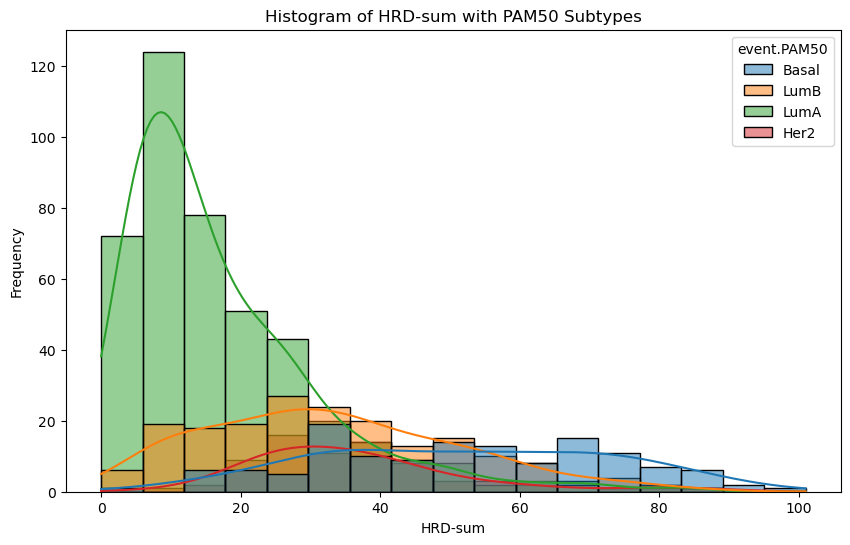

event.PAM50
LumA     430
LumB     188
Basal    133
Her2      73
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=metadata, x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
plt.title('Histogram of HRD-sum with PAM50 Subtypes')
plt.xlabel('HRD-sum')
plt.ylabel('Frequency')
plt.show()
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)

(316, 34) (114, 34)


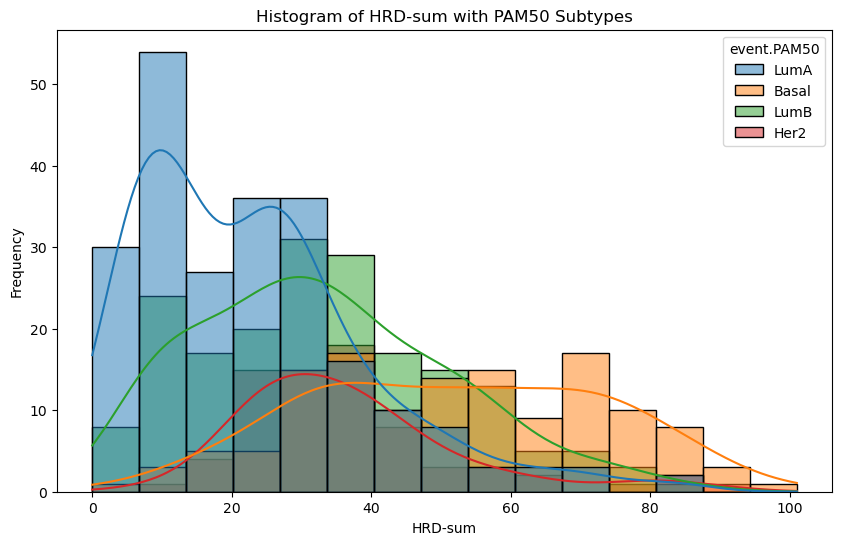

event.PAM50
LumA     228
LumB     188
Basal    133
Her2      73
Name: count, dtype: int64
(633, 34)


In [27]:
lumA_cutoff = 23
lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
print(lumA_HRP.shape, lumA_HRD.shape)
lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])

# plt.figure(figsize=(10, 6))
# sns.histplot(data=df_downsampled, x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
# plt.title('Histogram of HRD-sum with PAM50 Subtypes')
# plt.xlabel('HRD-sum')
# plt.ylabel('Frequency')
# plt.show()

pam50_counts = df_downsampled['event.PAM50'].value_counts()
print(pam50_counts)
print(df_downsampled.shape)

In [12]:
features_df = deconvo.loc[deconvo.index.intersection(df_downsampled.index)]
features_df = features_df.sort_index()

In [13]:
# Dont hv to use idk_kmn cuz all 549 intersect
idk_kmn = df_downsampled.loc[df_downsampled.index.intersection(deconvo.index)]
labels_df = idk_kmn['HRD-sum']
labels_df = labels_df.sort_index()
labels = labels_df.squeeze()
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)


In [14]:
unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
unused_majority 

add_back_features = deconvo.loc[deconvo.index.intersection(unused_majority.index)]
add_back_features = add_back_features.sort_index()

add_back_y = unused_majority.loc[unused_majority.index.intersection(deconvo.index)]
add_back_y = add_back_y.sort_index()

X_test = pd.concat([X_test, add_back_features])
y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])

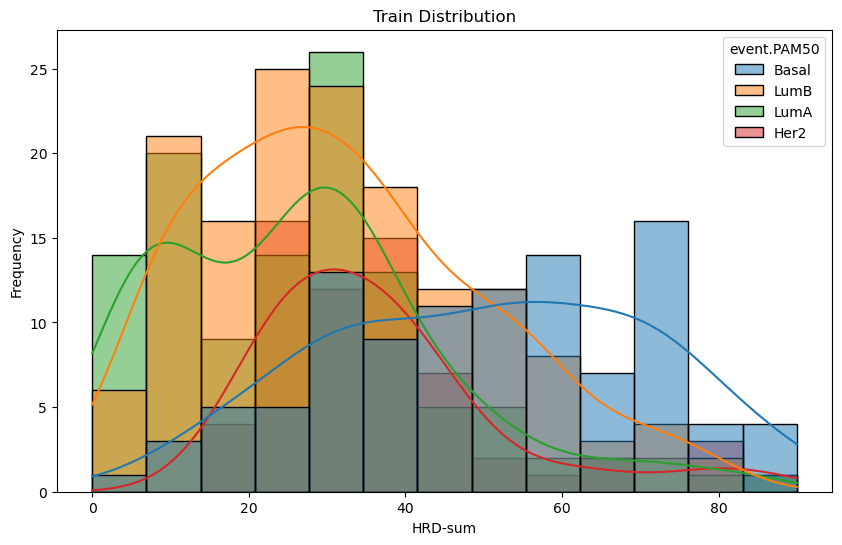

event.PAM50
LumB     188
LumA     144
Basal    133
Her2      73
Name: count, dtype: int64
(549, 34)


In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)], x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
plt.title('Train Distribution')
plt.xlabel('HRD-sum')
plt.ylabel('Frequency')
plt.show()

pam50_counts = df_downsampled['event.PAM50'].value_counts()
print(pam50_counts)
print(df_downsampled.shape)

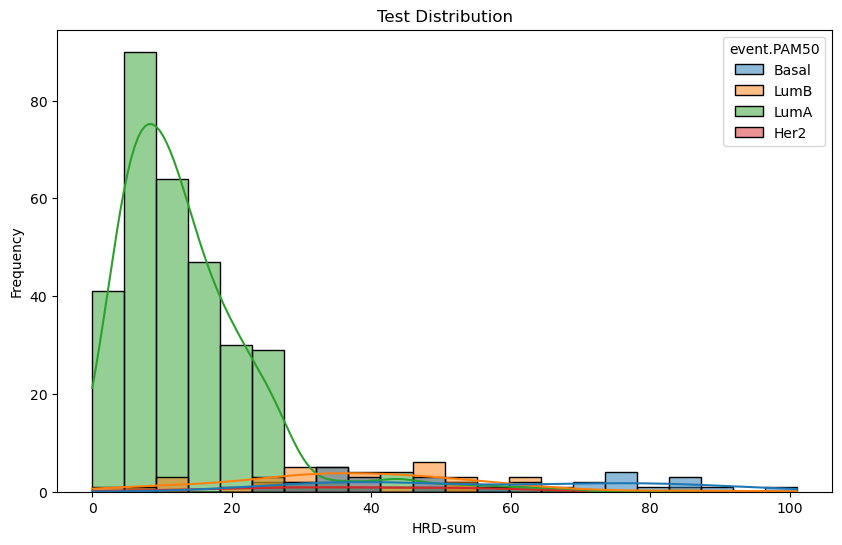

event.PAM50
LumB     188
LumA     144
Basal    133
Her2      73
Name: count, dtype: int64
(549, 34)


In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)], x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
plt.title('Test Distribution')
plt.xlabel('HRD-sum')
plt.ylabel('Frequency')
plt.show()

pam50_counts = df_downsampled['event.PAM50'].value_counts()
print(pam50_counts)
print(df_downsampled.shape)

## Regression: Takes 250 hrs 6-cpu

{'alpha': 0.01, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.628e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.643e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.25, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.998e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5, 'l1_ratio': 0.9}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.715e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.1}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.361e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.5}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+03, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.7}


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e+02, tolerance: 1.819e+01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1.0, 'l1_ratio': 0.9}


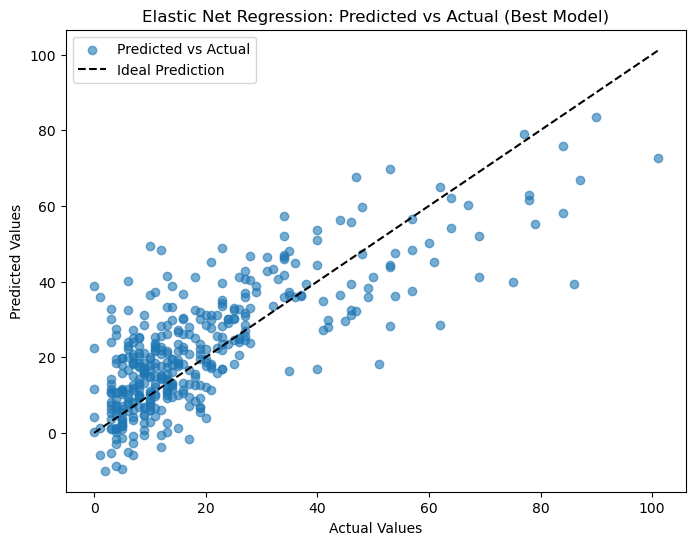

Best Parameters: {'alpha': 1.0, 'l1_ratio': 0.1}
Mean Squared Error: 142.081
R^2 Score: 0.561


In [17]:

from sklearn.model_selection import ParameterGrid

# Elastic Net Training & Evaluation with Grid Search
def train_evaluate_elastic_net_with_grid_search(X_train, X_test, y_train, y_test, alphas, l1_ratios):
    """
    Trains and evaluates Elastic Net models for a grid of hyperparameters.
    Returns the best model and its metrics.
    """
    best_model = None
    best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
    best_params = {}

    # Grid search
    param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})
    for params in param_grid:
        print(params)
        model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Update best model if current is better
        if mse < best_metrics['Mean Squared Error']:
            best_model = model
            best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
            best_params = params

    # Scatter plot of predictions vs actual values for the best model
    y_pred_best = best_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
    plt.legend(loc="upper left")
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")
    
    return best_model, best_metrics, best_params

# Main Execution with Hyperparameter Grid Search




# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# Define hyperparameter ranges
alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.7, 0.9]

elastic_model, metrics, params = train_evaluate_elastic_net_with_grid_search(
    X_train, X_test, y_train, y_test, alphas, l1_ratios
)





In [18]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]
breast_filt = genes_validation_transposed_sorted[genes_validation_transposed_sorted.index.str.contains('BREAST')]
breast_filt

Description,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
AU565_BREAST,32.0,1231.0,3.0,1.0,0.0,0.0,3.0,4.0,152.0,2582.0,...,1146916.0,6.0,3.0,8.0,389708.0,146916.0,24.0,364079.0,2.0,7.0
BT20_BREAST,21.0,853.0,2.0,0.0,1.0,3.0,4.0,10.0,141.0,3214.0,...,1643737.0,7.0,3.0,7.0,558184.0,182410.0,48.0,745031.0,1.0,6.0
BT474_BREAST,3.0,911.0,5.0,9.0,2.0,3.0,6.0,3.0,58.0,187.0,...,1169056.0,8.0,9.0,22.0,522991.0,165302.0,44.0,733933.0,10.0,3.0
BT483_BREAST,19.0,1306.0,5.0,4.0,7.0,4.0,15.0,12.0,69.0,33.0,...,1547088.0,11.0,9.0,9.0,798460.0,320052.0,45.0,1245412.0,3.0,35.0
BT549_BREAST,14.0,1214.0,8.0,11.0,6.0,3.0,7.0,11.0,42.0,57.0,...,1039147.0,12.0,4.0,16.0,513498.0,160632.0,16.0,644871.0,2.0,6.0
CAL120_BREAST,7.0,630.0,3.0,1.0,5.0,0.0,3.0,2.0,26.0,31.0,...,550124.0,9.0,3.0,6.0,281034.0,83378.0,20.0,229436.0,4.0,7.0
CAL148_BREAST,10.0,1949.0,6.0,5.0,5.0,6.0,10.0,27.0,257.0,1494.0,...,1422127.0,7.0,6.0,9.0,607899.0,212433.0,31.0,1044307.0,8.0,39.0
CAL51_BREAST,2.0,1237.0,2.0,3.0,2.0,1.0,5.0,3.0,30.0,221.0,...,785289.0,5.0,7.0,8.0,410039.0,141330.0,18.0,413946.0,4.0,8.0
CAL851_BREAST,51.0,988.0,10.0,21.0,12.0,8.0,33.0,8.0,113.0,272.0,...,4067011.0,47.0,14.0,3108.0,1621072.0,570312.0,496.0,2169530.0,14.0,95.0
CAMA1_BREAST,13.0,1312.0,11.0,6.0,6.0,7.0,9.0,17.0,99.0,59.0,...,2304663.0,17.0,17.0,1286.0,879298.0,255524.0,66.0,1431185.0,84.0,8.0


In [19]:
breast_filt = np.log2(breast_filt+1)
breast_filt.index = breast_filt.index.str.split('_').str[0]
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deconvo.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deconvo.columns))

feature_columns = breast_filt_aligned.columns  # Adjust if necessary
X = breast_filt_aligned[feature_columns]

# Generate predictions
predictions = elastic_model.predict(X)

# Add the predictions to the DataFrame
breast_filt_aligned['Predictions'] = predictions
predictions

Are columns aligned? True


array([52.34750613, 49.81406144, 48.96917918, 46.75017353, 36.79760376,
       24.77641117, 29.96415661, 37.37733398, 81.45730974, 35.57359082,
       16.96078677, 54.64315151, 57.14560992, 74.35519296, 60.70103868,
       49.442298  , 39.31727288, 76.21554181, 55.99355061, 55.69818993,
       55.62216232, 66.8396077 , 67.26457697, 57.34375993, 72.96726149,
       28.44132531, 48.8333085 , 72.91562194, 60.36465127, 69.6775705 ,
       41.98432321, 43.81110071, 50.7150939 , 64.25346959, 40.15694343,
       37.88904855, 26.95522153, 51.06455169, 25.32968558, 24.6936104 ,
       62.30978586, 37.59211198, 51.74965978, 38.99935956, 48.07337442,
       49.04817537, 51.37418477, 36.22172527, 62.60762556, 34.33468195,
       44.96580797])

In [20]:
import pandas as pd
import numpy as np

# Load the data
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

# Define PARP inhibitors
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']

# Filter and select specific drugs
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']].copy()

# Apply transformations explicitly
parpi_resp_filt['IC50'] = parpi_resp_filt['IC50'].clip(lower=1e-6)
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])

parpi_resp_filt["Cell Line Name"] = parpi_resp_filt["Cell Line Name"].str.replace("-", "", regex=True)

merged_df = breast_filt_aligned.merge(
    parpi_resp_filt,
    right_on ='Cell Line Name',
    left_index=True
)
subset_df = merged_df[['Cell Line Name', 'Drug Name', 'Predictions', 'log10IC50']]
subset_df

,Cell Line Name,Drug Name,Predictions,log10IC50
31,AU565,Olaparib,52.347506,0.649300
81,AU565,Veliparib,52.347506,0.728449
275,AU565,Rucaparib,52.347506,0.618083
323,AU565,Niraparib,52.347506,0.658753
370,AU565,Talazoparib,52.347506,0.446904
...,...,...,...,...
30,ZR7530,Olaparib,44.965808,0.774099
80,ZR7530,Veliparib,44.965808,0.791624
274,ZR7530,Rucaparib,44.965808,0.785756
322,ZR7530,Niraparib,44.965808,0.690543


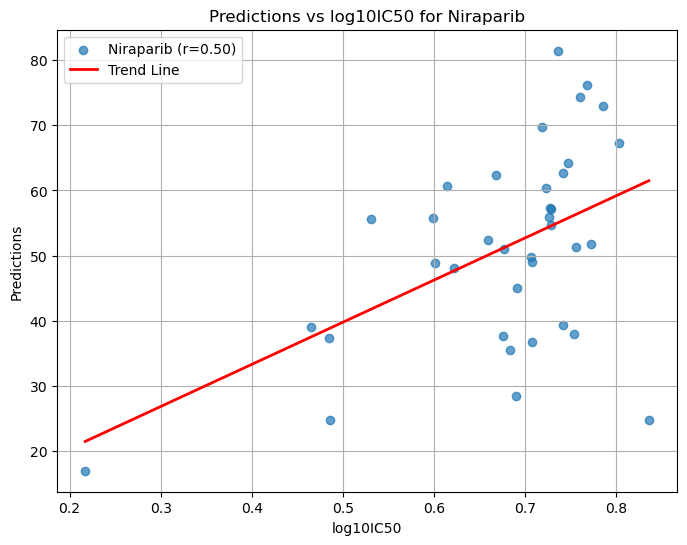

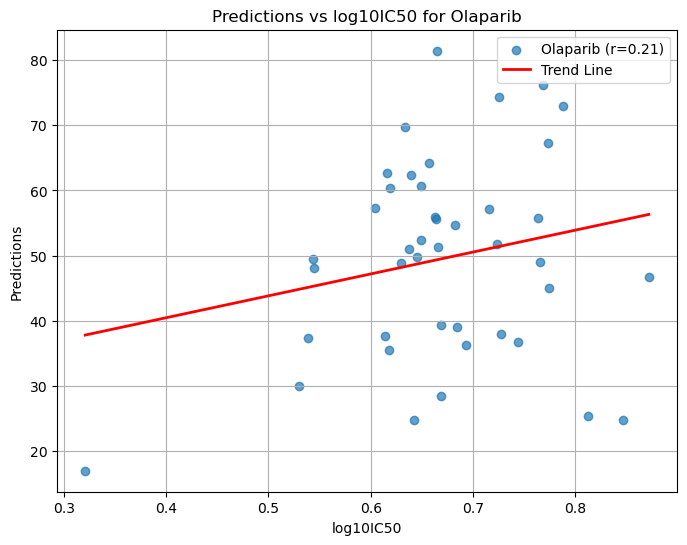

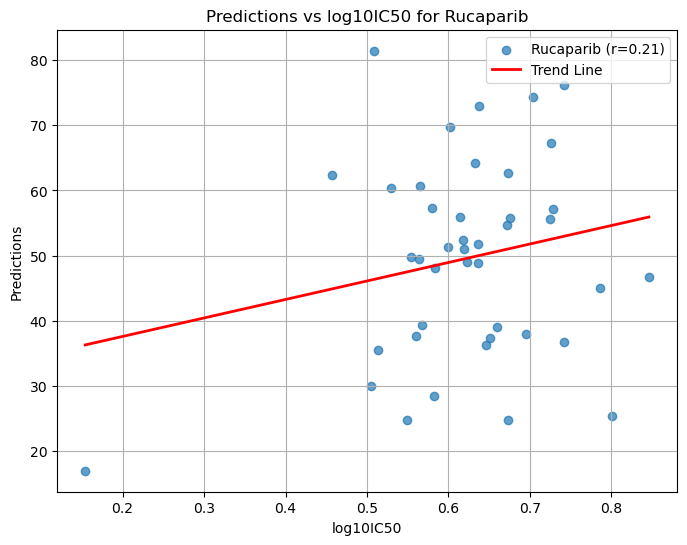

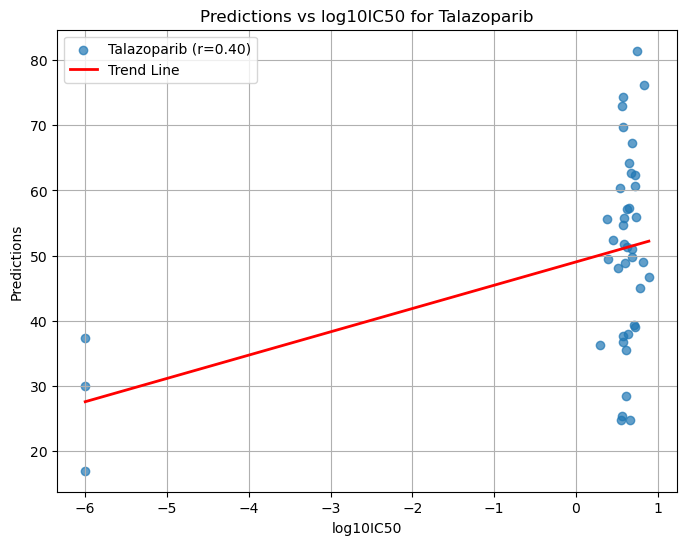

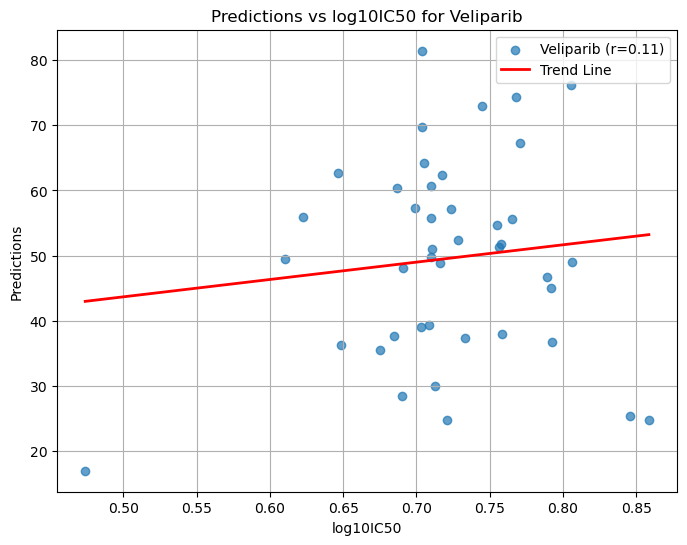

Niraparib: Correlation Coefficient = 0.50, P-Value = 0.0017
Olaparib: Correlation Coefficient = 0.21, P-Value = 0.1748
Rucaparib: Correlation Coefficient = 0.21, P-Value = 0.1847
Talazoparib: Correlation Coefficient = 0.40, P-Value = 0.0078
Veliparib: Correlation Coefficient = 0.11, P-Value = 0.4688


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from numpy.polynomial.polynomial import Polynomial

# Group the DataFrame by 'Drug Name'
grouped = merged_df.groupby('Drug Name')

# Initialize a dictionary to store correlation coefficients
correlation_results = {}

# Loop through each group and create a plot
for drug_name, group in grouped:
    # Calculate Pearson correlation coefficient
    corr_coef, p_value = pearsonr(group['log10IC50'], group['Predictions'])
    correlation_results[drug_name] = {
        'Correlation Coefficient': corr_coef,
        'P-Value': p_value
    }
    
    # Fit a linear trend line
    poly = Polynomial.fit(group['log10IC50'], group['Predictions'], deg=1)
    x_line = np.linspace(group['log10IC50'].min(), group['log10IC50'].max(), 100)
    y_line = poly(x_line)

    # Plot the scatter plot with trend line
    plt.figure(figsize=(8, 6))
    plt.scatter(group['log10IC50'], group['Predictions'], label=f'{drug_name} (r={corr_coef:.2f})', alpha=0.7)
    plt.plot(x_line, y_line, color='red', label='Trend Line', linewidth=2)
    plt.title(f'Predictions vs log10IC50 for {drug_name}')
    plt.xlabel('log10IC50')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    plt.show()

# Display correlation results
for drug, stats in correlation_results.items():
    print(f"{drug}: Correlation Coefficient = {stats['Correlation Coefficient']:.2f}, P-Value = {stats['P-Value']:.4f}")


In [22]:
# Step 1: Extract coefficients
coefficients = elastic_model.coef_

# Step 2: Calculate the absolute values of the coefficients
absolute_coefficients = np.abs(coefficients)

# Step 3: Get the indices of the top 300 coefficients
top_300_indices = np.argsort(absolute_coefficients)[-100:]  # Get indices of the largest 300 coefficients

# Step 4: Retrieve the corresponding column names from `deconvo`
top_300_genes = deconvo.columns[top_300_indices]

# Display the top genes
print(f"Top 300 genes associated with the model: {top_300_genes}")
top_genes = list(top_300_genes)


Top 300 genes associated with the model: Index(['ERBB4', 'IGF1R', 'RHOU', 'NXPH4', 'MUC20', 'B4GALNT4', 'CEBPD',
       'PPP1R1B', 'CD163L1', 'ELF5', 'GRB14', 'ARIH2OS', 'CSPG4', 'VSTM2A',
       'TFF1', 'C17orf58', 'SCNN1A', 'GBP5', 'DAPP1', 'SYBU', 'TMEM98',
       'MPV17L', 'C20orf96', 'ATAD3C', 'CLDN3', 'ZNF626', 'NOVA1', 'RPP21',
       'KLHL23', 'CDH7', 'QPRT', 'HLA-G', 'DSCR8', 'C1QB', 'ACTG2', 'ZBTB16',
       'GSTM1', 'VWA5A', 'IL20', 'PHYHD1', 'FAM3B', 'PTP4A1', 'REEP6',
       'EFCAB1', 'CHADL', 'ERP27', 'ZBTB18', 'CRACR2B', 'SDR42E1', 'NBPF15',
       'CLN3', 'CACNA1D', 'COL10A1', 'KRT17', 'SCRN1', 'CAPN12', 'GDF15',
       'PITX1', 'CDCA7L', 'FAM27C', 'TLX1', 'IDH2', 'CEACAM6', 'ID4',
       'ANKRD35', 'TFRC', 'CLDN4', 'ST8SIA1', 'MT1E', 'MLF1', 'TBX1', 'GSTT2B',
       'TFF3', 'CYP51A1', 'ELL3', 'SLC12A2', 'SPA17', 'BARX2', 'SFN', 'IZUMO4',
       'ATF7IP2', 'GNA14', 'ANO9', 'PEX11A', 'ECHDC3', 'MIA', 'ZNF804B',
       'MST1R', 'MISP', 'OVOL1', 'LMX1B', 'NAT1', 'AREG', 'T

In [23]:

actual228 = ['MXRA8',
'PRKCZ',
'MEGF6',
'FBXO2',
'UBXN10',
'SYTL1',
'CITED4',
'C1orf210',
'GPX7',
'GBP4',
'VAV3',
'MLLT11',
'ATP1A4',
'KLHDC9',
'RABGAP1L',
'FMOD',
'RAB29',
'ZBTB18',
'SH3YL1',
'ATP6V1E2',
'UBE2E3',
'FRZB',
'PPIL3',
'PECR',
'TMEM198',
'STK11IP',
'IRS1',
'KIF1A',
'NUP210',
'ALS2CL',
'IP6K2',
'DALRD3',
'APEH',
'CACNA1D',
'FHIT',
'MTRNR2L12',
'COPG1',
'DHX36',
'USP13',
'MAGEF1',
'SENP2',
'ZNF718',
'AREG',
'SLC7A11',
'MAP9',
'SORBS2',
'FRG1',
'NADK2',
'FAM174A',
'DTWD2',
'PCDHB4',
'PCDH1',
'THOC3',
'SIMC1',
'F12',
'FAM135A',
'OGFRL1',
'CD109',
'RRAGD',
'WASF1',
'ACAT2',
'SNX10',
'SCRN1',
'NCF1',
'TMEM120A',
'AZGP1',
'SMKR1',
'PODXL',
'AKR1B1',
'TMEM139',
'SPIDR',
'TPD52',
'CA13',
'ATP6V1C1',
'BAALC',
'AARD',
'EXT1',
'SAMD12',
'MAL2',
'TAF2',
'MTBP',
'ZHX1',
'FBXO32',
'SQLE',
'LRRC6',
'VLDLR',
'SIGMAR1',
'ALDH1B1',
'CKS2',
'SYK',
'PHYHD1',
'PTGES',
'BET1L',
'RIC8A',
'SIRT3',
'RNH1',
'LRRC56',
'IRF7',
'PNPLA2',
'CRACR2B',
'ASCL2',
'TSSC4',
'PPFIBP2',
'CTR9',
'CD44',
'TCN1',
'FADS2',
'ME3',
'DCUN1D5',
'CLMP',
'SPA17',
'TMEM218',
'FOXRED1',
'GLB1L2',
'ANKRD30A',
'PDCD4',
'TACC2',
'TEAD4',
'LAG3',
'ZNF605',
'ZNF10',
'BRCA2',
'N4BP2L2',
'EXOSC8',
'COG3',
'PHF11',
'EBPL',
'IPO5',
'TEX30',
'IRS2',
'CARS2',
'ING1',
'TFDP1',
'GSC',
'SLC25A29',
'JAG2',
'RASL12',
'LARP6',
'ZNF592',
'AEN',
'ACAN',
'HAPLN3',
'MFGE8',
'FANCI',
'POLG',
'ANPEP',
'ARPIN',
'GDPGP1',
'NGRN',
'HDDC3',
'UNC45A',
'RCCD1',
'PRC1',
'ASB7',
'SNRPA1',
'IL32',
'BOLA2B',
'IRX6',
'MT1G',
'PLEKHG4',
'C16orf95',
'GALNS',
'CBFA2T3',
'CPNE7',
'YWHAE',
'INPP5K',
'GABARAP',
'KDM6B',
'ZSWIM7',
'TTC19',
'LYRM9',
'UNC119',
'NEK8',
'TRAF4',
'PGAP3',
'JUP',
'ACLY',
'NKIRAS2',
'BRCA1',
'TMUB2',
'EFTUD2',
'FMNL1',
'PRR15L',
'DCAF7',
'TACO1',
'LRRC37A3',
'SLC39A11',
'ARMC7',
'MIF4GD',
'WBP2',
'EVPL',
'SEC14L1',
'TK1',
'SOCS3',
'CANT1',
'CARD14',
'RPTOR',
'ALYREF',
'FOXK2',
'FN3KRP',
'FN3K',
'TMEM241',
'MOCOS',
'NFATC1',
'C20orf96',
'RBCK1',
'FAM110A',
'SLC4A11',
'DZANK1',
'CD40',
'SLC25A23',
'LRRC8E',
'FXYD5',
'SYNE4',
'BCKDHA',
'CNFN',
'CXCL17',
'PVR',
'ZNF583',
'ZNF419',
'TMEM191B',
'TOP3B',
'PRAME',
'PLA2G6',
'NPTXR',
'ODF3B',
'PCP4',
'RSPH1']

In [24]:
print(set(top_genes) & set(actual228))
print(len(set(top_genes) & set(actual228)))

{'PHYHD1', 'AREG', 'C20orf96', 'BRCA1', 'CACNA1D', 'SPA17', 'SCRN1', 'ZBTB18', 'CRACR2B'}
9


In [25]:
print(len(top_genes))

100


In [26]:
for i in top_genes:
    if i[0] == 'B':
        print(i)

B4GALNT4
BARX2
BRCA1
